<h1 style="text-align: center;">7. Clasificación</h1>
<h2 style="text-align: center;">Redes neuronales artificiales</h2>

------------------------------------------------------------------------


Elaborado por el Dr. Carlos Francisco Méndez para la asignatura de Introducción a la Ciencia de Datos de la Licenciatura en Ciencias Genómicas

## Objetivo

Entrenar un modelo de red neuronal artificial profunda para resolver una tarea de clasificación multiclase usando PyTorch.

Notebook adaptado de la [Capacitación oficial de PyTorch.](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

## Descripción de la tarea

En este taller vamos a user el conjunto de datos FashionMNIST. El modelo debe clasificar imágenes de elementos de vestimenta en una de 10 posibles categorías:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot        
    
Ejemplos de entrada:
<img 
    style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 50%;"
    src="fashion-mnist-sprite.png" 
    alt="FashionMNIST">
</img>



------------------------------------------------------------------------


## Importación de librerías

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score


## Descarga y creación de conjuntos de entrenamiento y prueba

Usaremos dos objetos de PyTorch para manejo de datos:
* Dataset: permite almacenar conjuntos de datos en forma de `Ejemplo - Etiqueta`.
* DataLoader: permite iterar a través del conjunto de datos.

El módulo `torchvision.datasets` contiene objetos de la clase `Dataset` para acceder a diversos conjuntos de datos disponibles para uso libre. 

Usaremos el conjunto de datos `FashionMNIS`. El argumento `transform` permite transformar los datos en tensores con el parámetro ToTensor() y el argumento `download=True` indica que el dataset debe ser descargado.

Dividimos el conjunto de datos en dos subconjuntos. Unos será usado para el entrenamiento de la red (`train_data`) y el otro para evaluarla (`test_data`).


In [15]:
data = pd.read_csv("../data/cvd_transformed.csv")
data.head(6)



X = data.iloc[:, np.r_[2, 8:12, 14:15]]
y = data.iloc[:, 13]  # all rows, label only
print("Datos")
print(X.head())
print("Categorias de clase")
print(y.head())

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print("Datos")
print(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

Datos
    age_year  cholesterol  gluc  smoke  alco        bmi
0  50.391781            1     1      0     0  21.967120
1  55.419178            3     1      0     0  34.927679
2  51.663014            3     1      0     0  23.507805
3  48.282192            1     1      0     0  28.710479
4  47.873973            1     1      0     0  23.011177
Categorias de clase
0    0
1    1
2    1
3    1
4    0
Name: cardio, dtype: int64
Datos
[[-0.41252876 -0.51957914 -0.38479629 -0.30994665 -0.23537015 -1.12322809]
 [ 0.33066899  2.48212624 -0.38479629 -0.30994665 -0.23537015  1.82539772]
 [-0.22460301  2.48212624 -0.38479629 -0.30994665 -0.23537015 -0.77271049]
 ...
 [-0.06948326 -0.51957914 -0.38479629  3.22636167 -0.23537015  0.00528188]
 [ 1.2229113  -0.51957914  1.38952461 -0.30994665 -0.23537015  0.04437073]
 [ 0.45703285  0.98127355 -0.38479629 -0.30994665 -0.23537015 -0.45290544]]


------------------------------------------------------------------------


In [18]:


# Ensure X_train and y_train are numpy arrays
X_train = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train
y_train = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train

X_test = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test
y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use long for classification labels

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Creación de `DataLoader`

Definimos un tamaño de lote para que la red ajuste sus pesos cada 64 ejemplos (`batch_size = 64`).

Creamos dos objetos `DataLoader` para iterar ambos conjuntos de datos por lotes.


In [20]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


### Observación del DataLoader

Vamos a iterar sobre el DataLoader de prueba (`test_dataloader`) para ver observar la dimesionalidad del primer lote y su categoría.

In [21]:
for X, y in test_dataloader:
    print(f"Dimensionalidad de datos X [TamañoLote, CanalImag, LargoImag, AnchoImag]: {X.shape}")
    print(f"Dimensionalidad de categorías y: {y.shape}, tipo de categorías: {y.dtype}")
    break

Dimensionalidad de datos X [TamañoLote, CanalImag, LargoImag, AnchoImag]: torch.Size([64, 6])
Dimensionalidad de categorías y: torch.Size([64]), tipo de categorías: torch.int64


------------------------------------------------------------------------


## Definición de la red neuronal

### Definición de `device` para entrenamiento


In [22]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device a utulizar: {device}")


Device a utulizar: cpu


### Definición de arquitectura de la red neuronal

Creamos la clase `RedNeuronal` a partir de la clase base [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Esta clase será definida de acuerdo a la arquitectura de red que deseamos entrenar.

Debemos definir:
- Capas
- Nodos por capa
- Función de activación
- Procesamiento hacia adelante de la red (`forward`)

Al final indicamos que la red debe crearse en el `device` definido anteriormente.


In [23]:
# Define modelo
class RedNeuronal(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = RedNeuronal().to(device)
print(model)

RedNeuronal(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Definición de función de pérdida y optimizador

Para que la red neuronal aprenda debemos utilizar una [función de pérdida o loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) que mida las predicciones de la red y un [optimizador](https://pytorch.org/docs/stable/optim.html) que ajuste los pesos de la red neuronal para intenter predecir cada vez mejor, esto es, diminuir el valor de la función de pérdida.

La función de pérdida más recomendada para resolver tareas de clasificación multiclase es la Entropía crusada (`CrossEntropyLoss`).

El optimizador más sencillo es uno basado de el algortimo de Descenso por gradiente estocástico (`SGD`). La tasa de aprendizaje (learning rate o `lr`) será definida como 0.001.

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

### Definición de método de entrenamiento (`train`)

Esto incluye procesar los datos del `dataloader` lote por lote "hacia delante" y calcular el error de predicción de la red, esto es, el valor de la función de pérdida. Luego debemos propagar el error de predicción "hacia atrás" de la red para ajustar los pesos de los nodos. En cada iteración, la red ajustará los pesos para predecir cada vez mejor.


In [25]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Valor de función de pérdida: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Definición de método de prueba (`test`)

Esto incluye procesar los datos de prueba lote por lote, esto es, hacer que la red previamente entrenada realice predicciones sobre estos datos y acumular tanto el error (valor de la función de perdida) como los aciertos de la red (valor de exactitud o `Accuracy`).


In [26]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Fase de prueba: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

------------------------------------------------------------------------


## Entrenamiento de la red neuronal

Ejecutamos los métodos de entrenamiento (`train`) y prueba (`test`) por un número de épocas (veces que la red entrena usando todos los datos disponibles).

El `train` imprimirá el valor de pérdida por cada 100 lotes. El método `test` imprimirá el valro de pérdida y la exactitud de predicción.


In [27]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x6 and 784x512)

------------------------------------------------------------------------


## Guardar modelo entrenado

Para guardar nuestro modelo entrenado, almacenamos en un archivo los pesos ajustados finales de la red neuronal.


In [11]:
torch.save(model.state_dict(), "model.pth")
print("Guardamos modelo entrenado en model.pth")

Guardamos modelo entrenado en model.pth


------------------------------------------------------------------------


## Fase de inferencia


### Cargar modelo entrenado

Para usar nuestro modelo entrenado, creamos una instancia de la red neuronal y le cargamos los pesos almacenados.


In [12]:
model = RedNeuronal().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

### Usar modelo entrenado

Predecir con el modelo entrenado la categoría de nuevos datos. Como ejemplo, usemos la imagen 919 del conjunto de datos de prueba.


Categoría: Trouser


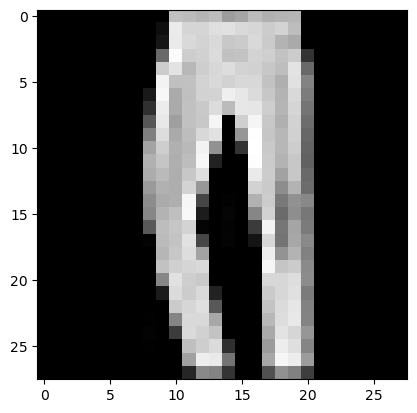

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

image, label = test_data[5]
pyplot.imshow(image[0], cmap='gray')
print('Categoría:', classes[label])

Usamos nuestro modelo entrenado en modo de evaluación `model.eval()` y sin ajustes de pesos: `torch.no_grad()`.

Imprimimos la categoría predicha por el modelo y la categoría verdadera.

In [15]:
model.eval()
x, y = test_data[5][0], test_data[5][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Categoría predicha: "{predicted}", Categoría verdadera: "{actual}"')

Categoría predicha: "Trouser", Categoría verdadera: "Trouser"


------------------------------------------------------------------------
